In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
df = pd.read_excel(io='Online Retail.xlsx', sheet_name='Online Retail')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

# Data Cleanup

In [5]:
df.loc[df['Quantity']<=0].shape

(10624, 8)

In [6]:
df = df.loc[df['Quantity']>0]

In [7]:
df.shape

(531285, 8)

In [8]:
df.dropna(subset=['CustomerID'], inplace=True)

In [9]:
df.shape

(397924, 8)

In [10]:
df = df.loc[
  df['InvoiceDate'] < '2011-12-01'
]

- Total Sales

In [11]:
df['Sales'] = df['Quantity'] * df['UnitPrice']

- Per Customer Data

Per-customer data: In order to analyze customer segments, we need to transform
our data, so that each record represents the purchase history of individual
customers.

In [12]:
customer_df = df.groupby('CustomerID').agg({
  'Sales':sum,
  'InvoiceNo':lambda x: x.nunique()
})

customer_df.columns = ['TotalSales', 'OrderCount']
customer_df['AvgOrderValue'] = customer_df['TotalSales'] / customer_df['OrderCount']
customer_df.head(10)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600000
12347.0,4085.18,6,680.863333
12348.0,1797.24,4,449.310000
12349.0,1757.55,1,1757.550000
12350.0,334.40,1,334.400000
12352.0,2506.04,8,313.255000
12353.0,89.00,1,89.000000
12354.0,1079.40,1,1079.400000
12355.0,459.40,1,459.400000


In [13]:
customer_df.describe()

,TotalSales,OrderCount,AvgOrderValue
count,4298.000000,4298.000000,4298.000000
mean,1952.818779,4.131689,400.255621
std,8354.913254,7.420253,1271.187289
min,0.000000,1.000000,0.000000
25%,304.305000,1.000000,178.602500
50%,657.265000,2.000000,295.033958
75%,1599.515000,4.000000,431.594250
max,268478.000000,201.000000,77183.600000


Now, as you can see from this data, the three columns, TotalSales, OrderCount, and
AvgOrderValue, have different scales. TotalSales can take any values from 0 to 26,848,
while OrderCount takes values between 1 and 201. Clustering algorithms are highly
affected by the scales of the data, so we need to normalize this data to be on the same scale.
We are going to take two steps to normalize this data. First, we are going to rank the data,
so that the values of each column range from 1 to 4298, which is the total number of
records.

In [14]:
rank_df = customer_df.rank(method='first')
rank_df.head(10)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,4290.0,1.0,4298.0
12347.0,3958.0,3470.0,3888.0
12348.0,3350.0,2861.0,3303.0
12349.0,3321.0,2.0,4238.0
12350.0,1241.0,3.0,2561.0
12352.0,3630.0,3774.0,2360.0
12353.0,119.0,4.0,201.0
12354.0,2781.0,5.0,4151.0
12355.0,1670.0,6.0,3354.0


In [15]:
normalized_df = (rank_df - rank_df.mean()) / rank_df.std()

In [16]:
normalized_df.head(15)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,1.724999,-1.731446,1.731446
12347.0,1.457445,1.064173,1.401033
12348.0,0.967466,0.573388,0.929590
12349.0,0.944096,-1.730641,1.683093
12350.0,-0.732148,-1.729835,0.331622
12352.0,1.193114,1.309162,0.169639
12353.0,-1.636352,-1.729029,-1.570269
12354.0,0.508917,-1.728223,1.612981
12355.0,-0.386422,-1.727417,0.970690


In [17]:
normalized_df.describe()

,TotalSales,OrderCount,AvgOrderValue
count,4298.000000,4298.000000,4.298000e+03
mean,0.000000,0.000000,-6.612776e-18
std,1.000000,1.000000,1.000000e+00
min,-1.731446,-1.731446,-1.731446e+00
25%,-0.865723,-0.865723,-8.657232e-01
50%,0.000000,0.000000,0.000000e+00
75%,0.865723,0.865723,8.657232e-01
max,1.731446,1.731446,1.731446e+00


Customer Segmentation via K-Means Clustering

The k-means clustering algorithm is a frequently used algorithm for drawing insights into
the formations and separations within data. In marketing, it is often used to build customer
segments and understand the behaviors of these different segments.

In [18]:
from sklearn.cluster import KMeans

In [19]:
kmeans = KMeans(n_clusters=4).fit(normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


As you can see from this code, we are building a clustering model that splits the data into
four segments. You can change the desired number of clusters with the n_clusters
parameter. Using the fit function, you can train a k-means clustering algorithm to learn to
split the given data. In this code, we are building four clusters, based on the TotalSales,
OrderCount, and AvgOrderValue values. The trained model object, kmeans, stores the
labels and centers of the clusters in the labels_ and cluster_centers_ attributes of the
model object.

In [20]:
kmeans.labels_

array([1, 3, 3, ..., 2, 0, 3], dtype=int32)

In [21]:
kmeans.cluster_centers_

array([[ 0.22927119,  0.72651836, -0.64266423],
       [-0.13229361, -0.84649738,  0.79586389],
       [-1.24090927, -0.79043908, -1.05914892],
       [ 1.20686658,  1.00577374,  0.86930797]])

In [22]:
four_cluster_df = normalized_df.copy(deep=True)
four_cluster_df['Cluster'] = kmeans.labels_

four_cluster_df.head(10)

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,1.724999,-1.731446,1.731446,1
12347.0,1.457445,1.064173,1.401033,3
12348.0,0.967466,0.573388,0.929590,3
12349.0,0.944096,-1.730641,1.683093,1
12350.0,-0.732148,-1.729835,0.331622,1
12352.0,1.193114,1.309162,0.169639,3
12353.0,-1.636352,-1.729029,-1.570269,2
12354.0,0.508917,-1.728223,1.612981,1
12355.0,-0.386422,-1.727417,0.970690,1


In [23]:
four_cluster_df = four_cluster_df.reset_index()

four_cluster_df.loc[
  four_cluster_df['Cluster']==2,
  ['CustomerID']
]

,CustomerID
6,12353.0
14,12361.0
24,12375.0
32,12386.0
42,12401.0
...,...
4291,18277.0
4292,18278.0
4293,18280.0
4294,18281.0


In [24]:
four_cluster_df['Cluster'].value_counts()

2    1159
3    1130
1    1067
0     942
Name: Cluster, dtype: int64

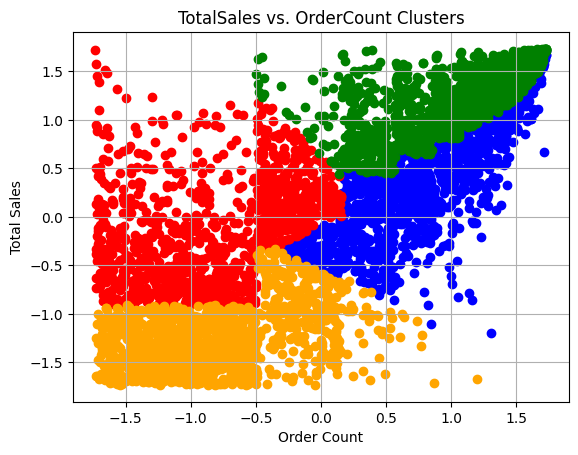

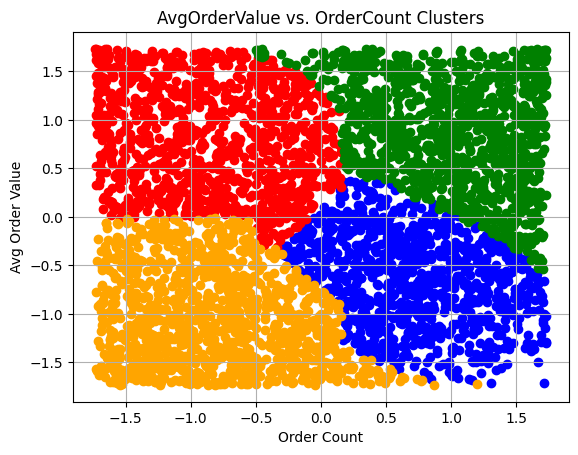

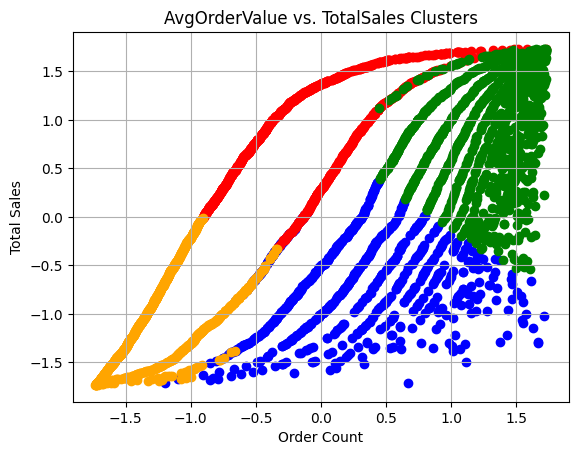

In [25]:
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'],
    c='blue'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'],
    c='red'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'],
    c='orange'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'],
    c='green'
)

plt.title('TotalSales vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Total Sales')

plt.grid()
plt.show()

#############################

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c='blue'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c='red'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
    c='orange'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
    c='green'
)

plt.title('AvgOrderValue vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Avg Order Value')

plt.grid()
plt.show()

#################

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c='blue'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c='red'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
    c='orange'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
    c='green'
)

plt.title('AvgOrderValue vs. TotalSales Clusters')
plt.xlabel('Order Count')
plt.ylabel('Total Sales')

plt.grid()
plt.show()

- Selecting the best number of clusters

In [26]:
from sklearn.metrics import silhouette_score

In [27]:
clusters = [4,5,6,7,8]

for n_cluster in clusters:
  kmeans = KMeans(n_clusters=n_cluster).fit(
    normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']]
  )
  
  silhouette_avg = silhouette_score(
    normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']],
    kmeans.labels_
  )
  
  print(f"Silhoutte score for {n_cluster} Clusters: %{silhouette_avg:.4f}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhoutte score for 4 Clusters: %0.4114


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhoutte score for 5 Clusters: %0.3779


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhoutte score for 6 Clusters: %0.3778


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhoutte score for 7 Clusters: %0.3910


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhoutte score for 8 Clusters: %0.3809


- Interpreting Customer Segments

In [28]:
kmeans = KMeans(n_clusters=4).fit(
  normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']]
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
four_cluster_df = normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']].copy(deep=True)
four_cluster_df['Cluster'] = kmeans.labels_
four_cluster_df.head(10)

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,1.724999,-1.731446,1.731446,2
12347.0,1.457445,1.064173,1.401033,3
12348.0,0.967466,0.573388,0.929590,3
12349.0,0.944096,-1.730641,1.683093,2
12350.0,-0.732148,-1.729835,0.331622,2
12352.0,1.193114,1.309162,0.169639,3
12353.0,-1.636352,-1.729029,-1.570269,1
12354.0,0.508917,-1.728223,1.612981,2
12355.0,-0.386422,-1.727417,0.970690,2


In [30]:
kmeans.cluster_centers_

array([[ 0.22888789,  0.72574146, -0.64245176],
       [-1.2440054 , -0.7917182 , -1.06203644],
       [-0.13723954, -0.85002014,  0.79054937],
       [ 1.20441747,  1.00058583,  0.87243288]])

Let's take a closer look at this. The second cluster has the lowest numbers for all three
attributes. This suggests that the second cluster contains customers with the smallest
amount of sales, smallest number of orders, and lowest average per-order value. This group
of customers is one of low-value customers. On the other hand, the fourth cluster has the
highest numbers for all three attributes. The customers in the fourth cluster have the greatest
amount of sales, greatest number of orders, and highest average per-order value. So, these
customers in the fourth cluster purchase expensive items and give the business the highest
revenue. You would typically want to focus your marketing efforts on this segment of
customers, as it will result in the highest return.
The customers in the first cluster are interesting. They make purchases relatively
frequently, as they have a medium-to-high cluster center value for OrderCount, but their
average per-order value is low, as the cluster center for AvgOrderValue is low. These are
the customers who make frequent purchases of low-value items. So, it would be perfect to
market items with low per-item prices to this segment of customers. The customers in the
third cluster are also interesting. Their contributions to the revenue and number of orders
are medium to low, looking at the centers of this cluster. However, their average per-order
value is high. These are the customers who buy expensive items infrequently. Thus, it
would be perfect to market expensive items to this segment of customers.

In [32]:
high_value_cluster = four_cluster_df.loc[
  four_cluster_df['Cluster']==3
]

high_value_cluster.head()

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12347.0,1.457445,1.064173,1.401033,3
12348.0,0.967466,0.573388,0.929590,3
12352.0,1.193114,1.309162,0.169639,3
12356.0,1.268868,0.158357,1.557375,3
12359.0,1.585581,0.574194,1.672617,3


In [34]:
customer_df.loc[high_value_cluster.index].describe()

,TotalSales,OrderCount,AvgOrderValue
count,1133.000000,1133.000000,1133.000000
mean,5623.133143,8.484554,617.698258
std,15471.814308,10.516476,766.751979
min,1019.520000,1.000000,215.450606
25%,1769.170000,4.000000,355.050000
50%,2735.370000,6.000000,442.688333
75%,4487.680000,10.000000,619.674545
max,268478.000000,192.000000,14844.766667


In [37]:
pd.DataFrame(
    df.loc[
        df['CustomerID'].isin(high_value_cluster.index)
    ].groupby('Description').count()[
        'StockCode'
    ].sort_values(ascending=False).head()
)

,StockCode
Description,
JUMBO BAG RED RETROSPOT,1140
REGENCY CAKESTAND 3 TIER,1080
WHITE HANGING HEART T-LIGHT HOLDER,1071
LUNCH BAG RED RETROSPOT,933
PARTY BUNTING,865
